# Tuning Learning Rates with *ktrain*

Neural networks have many hyperparameters that need to be set before training begins. While, in practice, many hyperparameters have fairly reasonable defaults (e.g., ReLu activation, Xavier initialization, a kernel size of 3 in Convolutional Neural Networks), some do not and should be tuned. One of these is the learning rate, which governs the degree to which weights are adjusted during training.  Even after arriving at a good initial learning rate, it has been shown that varying the learning rate during training is effective in helping to minimize loss and improve generalization. *ktrain* provides a number of built-in methods to make it easy to tune and adjust learning rates to more effectively minimize loss during training.

To demonstrate these capabilities, we will begin by loading some text data into NumPy arrays and defining a simple text classification model.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 
import ktrain

Using TensorFlow backend.


In [2]:
# load  and prepare data as you normally would in Keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import imdb
NUM_WORDS = 20000
MAXLEN = 400
def load_data():
    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=NUM_WORDS)
    x_train = sequence.pad_sequences(x_train, maxlen=MAXLEN)
    x_test = sequence.pad_sequences(x_test, maxlen=MAXLEN)
    return (x_train, y_train), (x_test, y_test)
(x_train, y_train), (x_test, y_test) = load_data()

In [3]:
# build a model as you normally would in Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
def get_model():
    model = Sequential()
    model.add(Embedding(NUM_WORDS, 50, input_length=MAXLEN))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
model = get_model()

To use *ktrain*, one simply wraps the model and the data in a Learner object using the ```get_learner``` function.  This Learner object will be used to help tune and train our network.

In [4]:
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data = (x_test, y_test))

The wrapped model and data are both directly accessible.  For instance, the model can be saved and loaded like normal in Keras (e.g,. ```learner.model.save('my_model.h5')```).  

### A Learning Rate Finder

The Learner object can be used to find the best learning rate for your model.  First, we use ```lr_find``` to track the loss as the learning rate is increased and then use ```lr_plot``` to identify the maximal learning rate associated with a falling loss.

In [5]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
25000/25000 [==============================] - 5s 197us/step - loss: 0.6932 - acc: 0.4902
Epoch 2/5
25000/25000 [==============================] - 5s 183us/step - loss: 0.6926 - acc: 0.5456
Epoch 3/5
25000/25000 [==============================] - 5s 189us/step - loss: 0.5968 - acc: 0.7288
Epoch 4/5
25000/25000 [==============================] - 5s 182us/step - loss: 0.3167 - acc: 0.8695
Epoch 5/5
 8032/25000 [========>.....................] - ETA: 3s - loss: 0.5864 - acc: 0.8430

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


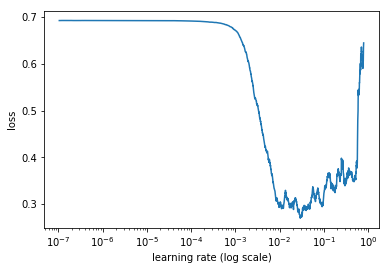

In [6]:
learner.lr_plot()

We would like the maximal learning rate associated with a still-falling loss (prior the loss diverging).  Based on the plot, we will start with a learning rate of 0.005.

## Interactive Training

It is sometimes advantageous to train interactively.  For instance, one can train a model for one or two epochs using one learning rate.  Then, based on the results, a higher or lower learning rate can be used for subsequent epochs.  *ktrain* makes such interactive training easy.  Here, using the fit method of the Learner object, we train a single epoch at the learning rate found previously and a second epoch at a slightly lower learning rate.  The first argument is the learning rate and the second argument is the number of epochs.

In [7]:
# reinitialize the model to train from scratch 
learner.set_model(get_model())

hist = learner.fit(0.005, 1)
hist = learner.fit(0.0005, 1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 5s 197us/step - loss: 0.4010 - acc: 0.8293 - val_loss: 0.2984 - val_acc: 0.8777
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 5s 183us/step - loss: 0.2105 - acc: 0.9283 - val_loss: 0.2869 - val_acc: 0.8860


## Using Learning Rate Schedules

In the example above, a static learning rate is used throughout each epoch.  It is sometimes beneficial to employ the use of learning rate schedules to *automatically* adjust the learning rate during the course training to more effectively minimize loss. Such adjustments can help jump out of suboptimal areas in the loss landscape and get to "sweet spots" with minimal loss that generalize well.  *ktrain* allows you to easily employ a variety of demonstrably effective learning rate policies during training. These include:

* a [triangular learning rate policy](https://arxiv.org/abs/1506.01186) available via the ```autofit``` method
* a [1cycle policy](https://arxiv.org/abs/1803.09820) available via the ```fit_onecycle``` method
* an [SGDR](https://arxiv.org/abs/1608.03983) (Stochastic Gradient Descent with Restart) schedule available using the ```fit``` method by supplying a *cycle_len* argument.


### SGDR
We will begin by covering SGDR. *ktrain* allows you to easily employ an SGDR learning rate policy in a similar style to that of the *fastai* library. We will begin with covering the cycle_len parameter.

**cycle_len:** When *cycle_len* is not None, the second argument fo ```fit``` is interpreted as the number of cycles instead of the number of epochs.  For instance, the following call runs 2 cycles each of length 2 epochs - totaling 4 (or 2 * 2) epochs.  The learning rate gradually decreases throughout the 2-epoch cycle and then restarts at 5e-3 at the start of a new 2-epoch cycle.  Decreases follow a functional form (cosine annealing). More information can be found in the original [SGDR paper](https://arxiv.org/abs/1608.03983).

In [8]:
# reinitialize the model to train from scratch 
learner.set_model(get_model())

# training using cycle_len 
learner.fit(5e-3, 2, cycle_len=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 6s 230us/step - loss: 0.4063 - acc: 0.8253 - val_loss: 0.3004 - val_acc: 0.8841
Epoch 2/4
25000/25000 [==============================] - 6s 223us/step - loss: 0.2265 - acc: 0.9209 - val_loss: 0.2874 - val_acc: 0.8872
Epoch 3/4
25000/25000 [==============================] - 6s 222us/step - loss: 0.2062 - acc: 0.9227 - val_loss: 0.2840 - val_acc: 0.8880
Epoch 4/4
25000/25000 [==============================] - 6s 227us/step - loss: 0.1397 - acc: 0.9555 - val_loss: 0.2812 - val_acc: 0.8894


The ```learner.plot``` method can be used to plot the training-validation loss (with 'loss' as argument) in addition to plotting the learning rate schedule with ('lr' as argument) and momentum schedule (with 'momentum' as argument) where applicable. Here, we plot the learning rate schedule employed by the previous call to ```learner.fit```.

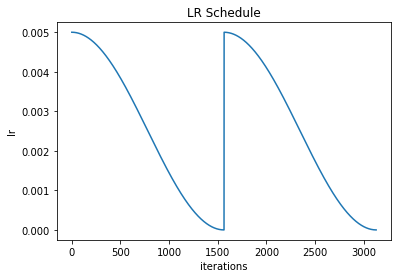

In [9]:
learner.plot('lr')

**cycle_mult:** The cycle_mult parameter allows you to increase the cycle length as training progresses.  For instance, cycle_mult=2 will double the length of the cycle.  In the example below, seven epochs are run:
- first cycle has length of one epoch
- second cycle has length two epochs
- third cycle has length of four epochs
Each cycle will begin at a learning rate of 5e-3 and gradually decrease until it resets at the beginning of the next cycle.

Note that the example below overfits. It is shown to merely illustrate the *cycle_mult* parameter.

In [10]:
# rebuild the model to train from scratch 
learner.set_model(get_model())

# training using cycle_len 
learner.fit(5e-3, 3, cycle_len=1, cycle_mult=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/7
25000/25000 [==============================] - 6s 235us/step - loss: 0.4295 - acc: 0.8241 - val_loss: 0.3478 - val_acc: 0.8704
Epoch 2/7
25000/25000 [==============================] - 6s 226us/step - loss: 0.2622 - acc: 0.9010 - val_loss: 0.2829 - val_acc: 0.8879
Epoch 3/7
25000/25000 [==============================] - 6s 225us/step - loss: 0.1782 - acc: 0.9408 - val_loss: 0.2776 - val_acc: 0.8900
Epoch 4/7
25000/25000 [==============================] - 6s 228us/step - loss: 0.1701 - acc: 0.9390 - val_loss: 0.2962 - val_acc: 0.8862
Epoch 5/7
25000/25000 [==============================] - 6s 227us/step - loss: 0.1170 - acc: 0.9613 - val_loss: 0.3159 - val_acc: 0.8832
Epoch 6/7
25000/25000 [==============================] - 6s 223us/step - loss: 0.0848 - acc: 0.9745 - val_loss: 0.3328 - val_acc: 0.8800
Epoch 7/7
25000/25000 [==============================] - 6s 222us/step - loss: 0.0704 - acc: 0.9816 - val_loss: 0.3355 - val_acc

Here is what the learning rate schedule looks like when using the **cycle_mult** parameter.

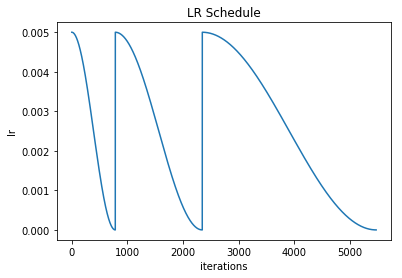

In [11]:
learner.plot('lr')

## Triangular Learning Rate Policy via ```autofit```

The ```autofit``` method in *ktrain* employs a default cyclical learning rate schedule that tends to work well in practice.  The default learning rate schedule in ```autofit``` is currently the [triangular learning rate policy](https://arxiv.org/abs/1506.01186), which some slight modifications.

The ```autofit``` method accepts two primary arguments. The first (required) is the learning rate (**lr**) to be used, which can be found using the learning rate finder above. The second is optional and indicates the number of epochs (**epochs**) to train.  If **epochs** is not supplied as a second argument, then ```autofit``` will train until the validation loss no longer improves after a certain period. This period can be configured using the **early_stopping** argument.  At the end of training, the weights producing the lowest validation loss are automatically loaded into the model, when **early_stopping** is enabled.  The ```autofit``` method can also automatically reduce the maximum (and base) learning rates in the triangular policy when validation loss no longer improves. This can be configured using the **reduce_on_plateau** and **reduce_factor** arguments to ```autofit```.  

Example:
```
learner.autofit(0.001, 20, reduce_on_plateau=2, reduce_factor=10)
```

The above will reduce the maximum and base learning rates in the triangular policy by a factor of 10 after two consecutive epochs of no improvement in validation loss.  Validation loss (i.e., val_loss) is the default criterion for both **early_stopping** and **reduce_on_plateau**.  To use validation accuracy instead, use invoke ```autofit``` with ```monitor='val_acc'```.

Here, we will use the ```autofit``` method and run the main training phase for two epochs.  

In [23]:
# rebuild the model to train from scratch 
learner.set_model(get_model())

# training using autofit
learner.autofit(0.005, 2)



begin training using triangular learning rate policy with max lr of 0.005...
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 7s 264us/step - loss: 0.4752 - acc: 0.7769 - val_loss: 0.3279 - val_acc: 0.8764
Epoch 2/2
25000/25000 [==============================] - 6s 255us/step - loss: 0.2541 - acc: 0.9061 - val_loss: 0.2851 - val_acc: 0.8880


The ```autofit``` method runs a triangular learning rate schedule with two modifications.  First, it annihilates the learning rate at the end of each cycle:

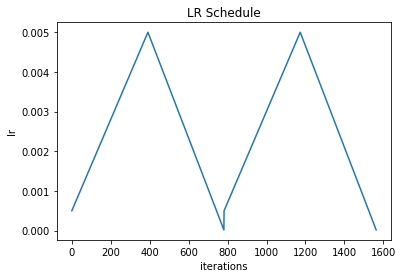

In [24]:
learner.plot('lr')

Second, if using the Adam, Nadam, or Adamax optimizers, it cycles the momentum between 0.85 and 0.95 in such a way that higher learning rates have lower momentum and lower learning rates have higher momentum, as suggested in [this paper](https://arxiv.org/pdf/1803.09820.pdf).

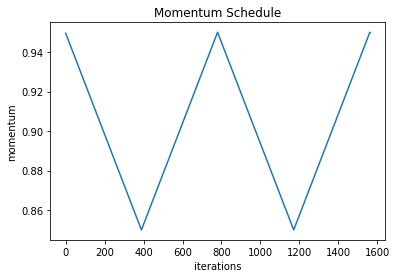

In [25]:
learner.plot('momentum')

### Additional Cooldowns
Since we are not [overfitting](https://en.wikipedia.org/wiki/Overfitting#Machine_learning) yet (i.e., validation loss is not increasing while training loss decreases), let's do a few more "cooldowns" starting at a smaller learning rate to improve the accuracy score further using the regular ```fit``` method that employs SGDR. These "cooldown" epochs will start the learning rate at 0.005/10 and gradually decrease it to a very small value.  We will use the **checkpoint_folder** argument covered earlier, so that we can restore the weights from any epoch in case we train too much and overfit.  If you are not using Linux, you should set this to your folder path of choice.

In [26]:
learner.fit(0.005, 1, cycle_len=1, checkpoint_folder='/tmp')

Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 6s 220us/step - loss: 0.1927 - acc: 0.9304 - val_loss: 0.2804 - val_acc: 0.8901


In [27]:
learner.fit(0.005/10, 1, cycle_len=1, checkpoint_folder='/tmp')

Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 6s 222us/step - loss: 0.1535 - acc: 0.9518 - val_loss: 0.2797 - val_acc: 0.8904


Note that we are running multiple short cooldown phases here - cycles of only one epoch. This essentially amounts to SGDR.  Although we are not doing it here, we can also run one longer cooldown by simply calling ```fit``` with a larger value for ```cycle_len``` and leaving the number of cycles at 1. 


## The 1cycle Policy

The [1cycle policy](https://arxiv.org/pdf/1803.09820.pdf) was proposed by Leslie Smith (as was the triangular learning rate policy).  The 1cycle policy runs a single triangular cycle over the course of training and then annihilates the learning rate to a near-zero value towards the end.

In [28]:
# rebuild the model to train from scratch 
learner.set_model(get_model())

# training using the 1cycle policy
learner.fit_onecycle(0.005, 3)



begin training using onecycle policy with max lr of 0.005...
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 7s 266us/step - loss: 0.5566 - acc: 0.7379 - val_loss: 0.3626 - val_acc: 0.8598
Epoch 2/3
25000/25000 [==============================] - 6s 252us/step - loss: 0.2684 - acc: 0.8990 - val_loss: 0.2864 - val_acc: 0.8870
Epoch 3/3
25000/25000 [==============================] - 6s 251us/step - loss: 0.1737 - acc: 0.9410 - val_loss: 0.2774 - val_acc: 0.8902


The 1cycle policy runs a single triangular cycle over all the epochs and also cycles the momentum in the shape of a *V*.

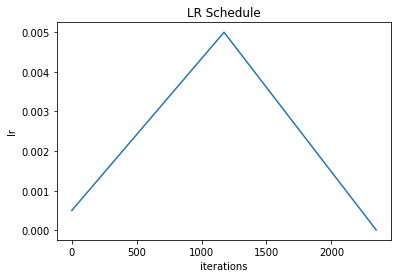

In [29]:
learner.plot('lr')

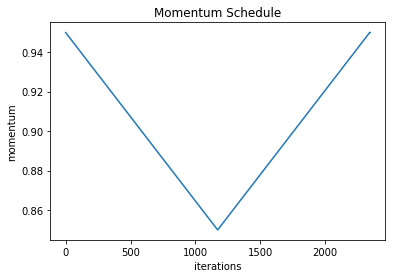

In [30]:
learner.plot('momentum')

The final accuracy here is **~89%** using only unigram feaures and a simple model. In the [text classification notebook](https://github.com/amaiya/ktrain/blob/master/tutorial-04-text-classification.ipynb), we show that an accuracy of **~92.3%** can be acheived on this dataset in mere seconds using built-in convenience methods in *ktrain*.